In [1]:
import matplotlib as plt
import textwrap

In [2]:
import sys
sys.path.append('..')
from utils import *

In [3]:
# arxiv_number_list=['1106.6060','1812.04213','2004.04168','2008.08998','2012.04554','2108.02159','2110.11330','2111.01152','2112.07523',]
arxiv_number_list = [
    "1010.1819",
    "1106.6060",
    "1208.0116",
    # "1212.5363", # TODO
    "1310.2674",
    "1812.04213",
    "2004.04168",
    "2008.08998",
    "2012.04554",
    "2108.02159",
    "2110.11330",
    "2111.01152",
    "2112.07523",
    "2308.03843",
    "2308.07488",
]
# '2308.03843'

In [4]:
len(set(arxiv_number_list))

14

In [5]:
import pandas as pd

In [6]:
def load_arxiv(arxiv_number):
    # Load arxiv and convert to dict
    prompt_template='../prompt_template.md'
    prompt_dict=load_prompt_template(prompt_template)
    with open(os.path.join('..',f'{arxiv_number}',f'{arxiv_number}.yaml'),'r') as f:
        kwargs= yaml.safe_load(f)
    # tasks = [f'Task:{idx+1} '+kwarg['task'] for idx,kwarg in enumerate(kwargs[1:])]
    tasks = [kwarg['task'] for idx,kwarg in enumerate(kwargs[1:])]
    score_dict={}
    for kwarg in kwargs[1:]:
        for key,value in (list(kwarg['score'].items())):
            assert isinstance(value, int), f'{arxiv_number}/{kwarg["task"]}:{key}:{value} is not int'
            if key not in score_dict:
                score_dict[key]=[value]
            else:
                score_dict[key].append(value)
    
    return pd.DataFrame(score_dict,index=tasks)

In [7]:
arxiv_dict_list={arxiv_number:load_arxiv(arxiv_number) for arxiv_number in arxiv_number_list}
execution=pd.concat(arxiv_dict_list.values(),keys=arxiv_dict_list.keys(),names=['arxiv_number','task'])

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_single_file(score_dict):
    x = np.arange(len(score_dict['task']))  # the label locations
    width = 0.15  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained',figsize=(8,5))
    color_list=[plt.cm.Blues(0.2+0.8*(i/6)) for i in range(6,0,-1)]
    for attribute, measurement in score_dict['score'].items():
        offset = width * multiplier
        rects = ax.barh(x + offset, np.array(measurement)+0.1, width, label=attribute,color=color_list[multiplier],left=-0.1)
        # ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_xlabel('Score')
    ax.set_xticks([0,1,2])
    ax.set_title(f"{score_dict['arxiv']} [mean={np.mean(score_dict['score']['final answer accuracy']):.2f}]")
    ax.set_yticks(x + width*4, ['\n'.join(textwrap.wrap(task, width=40)) for task in score_dict['task']],fontsize=8)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1],loc='upper left', ncols=1,bbox_to_anchor=(1, 1))

    ax.grid(axis='x',ls='--')
    # ax.set_ylim(0, 250)
    ax.set_xlim(-0.1,2.1)


In [9]:
color_list=[plt.cm.Blues(0.2+0.8*(i/6)) for i in range(6,0,-1)]

In [10]:
def plot_single_file(arxiv_df,arxiv_number):
    # arxiv_df=arxiv_dict_list['1010.1819']
    ax=arxiv_df.plot(kind='barh',figsize=(8,5),width=0.8,color=color_list,edgecolor='black')
    ax.grid(axis='x',ls='--')
    ax.set_ylabel('')
    ax.set_xlabel('Score')
    # ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=20)) for task in data_groupby_branch['Score']['mean'].sort_values().index],fontsize=7)
    ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=40)) for task in arxiv_df.index])
    ax.set_title(f"{arxiv_number}")

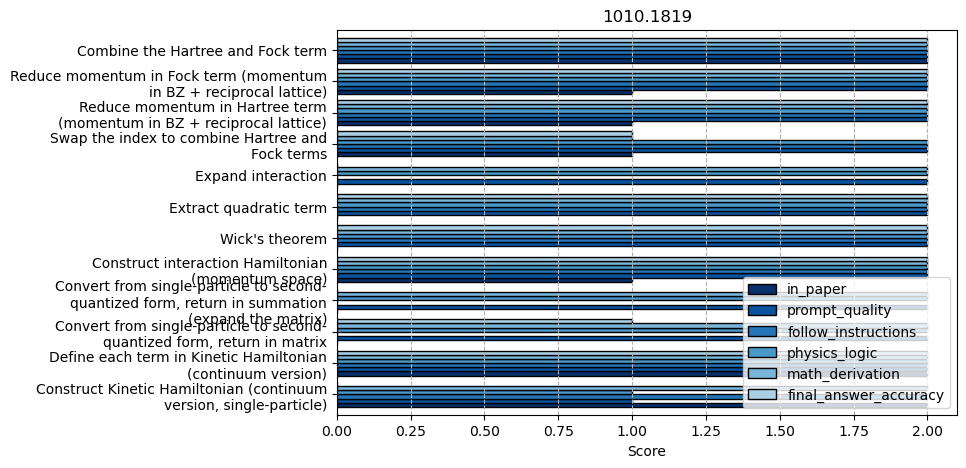

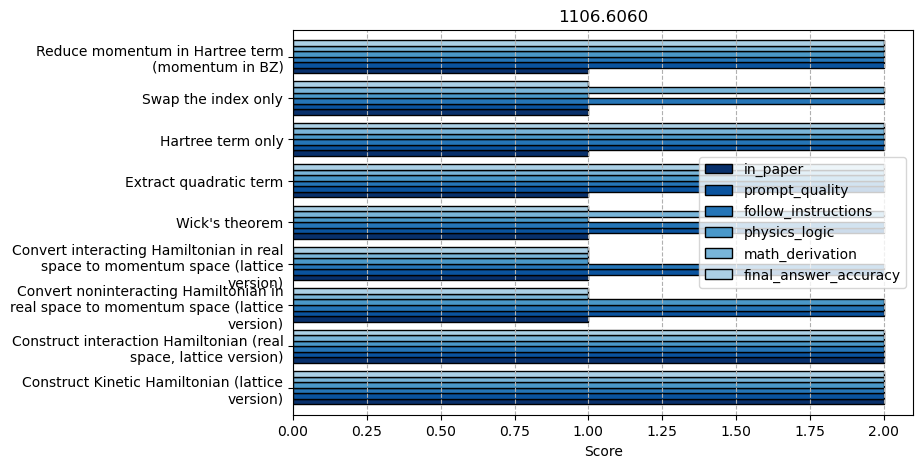

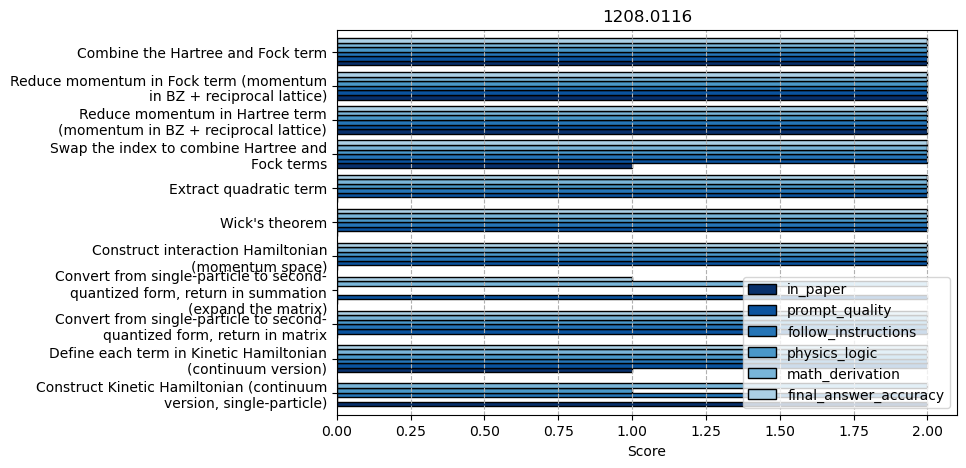

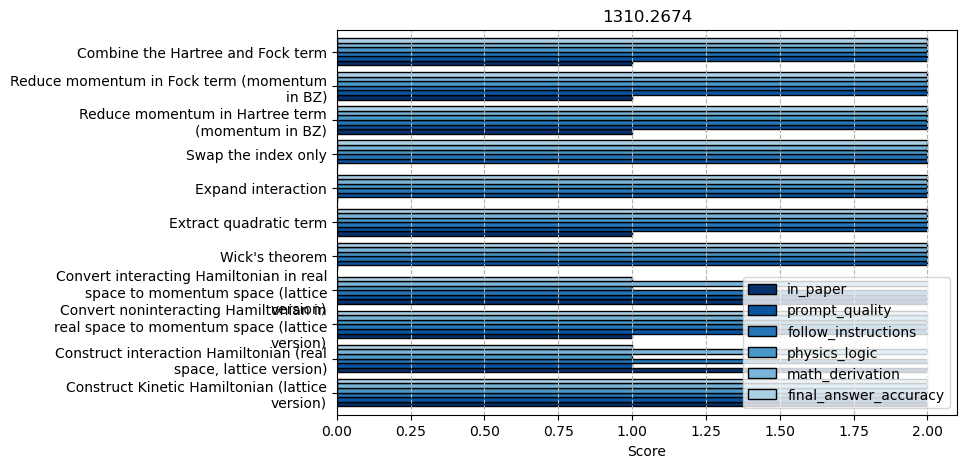

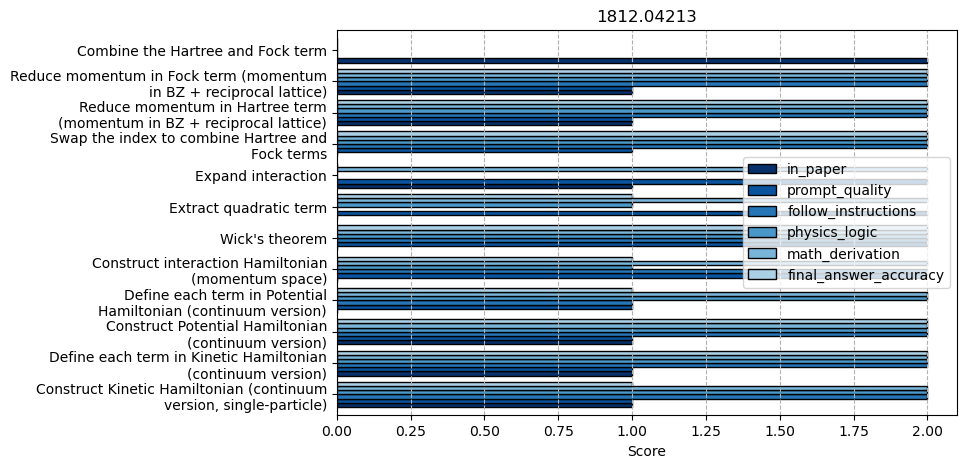

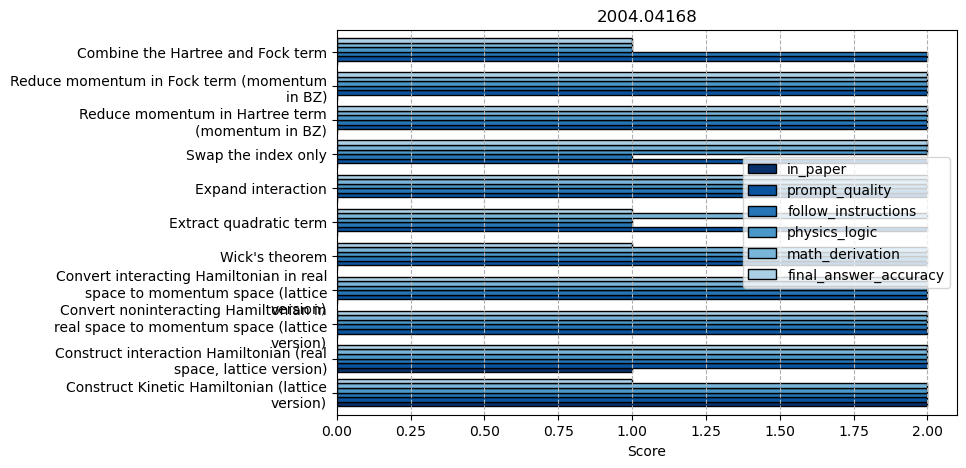

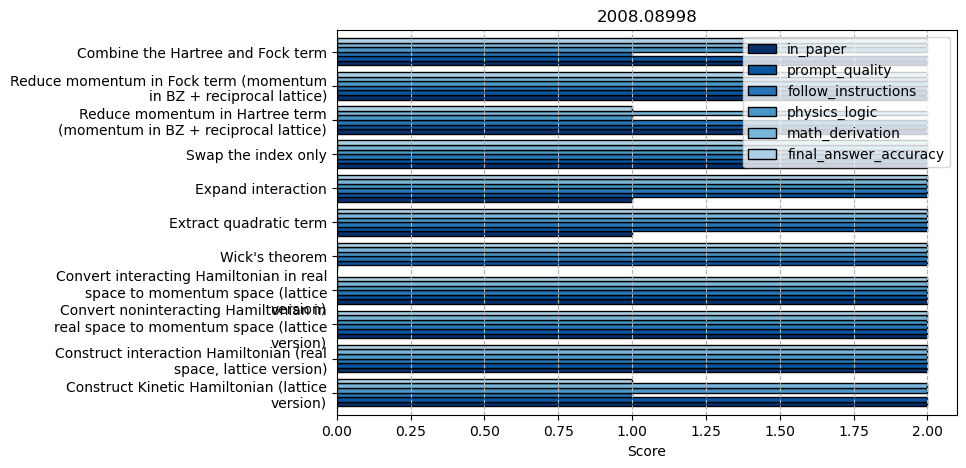

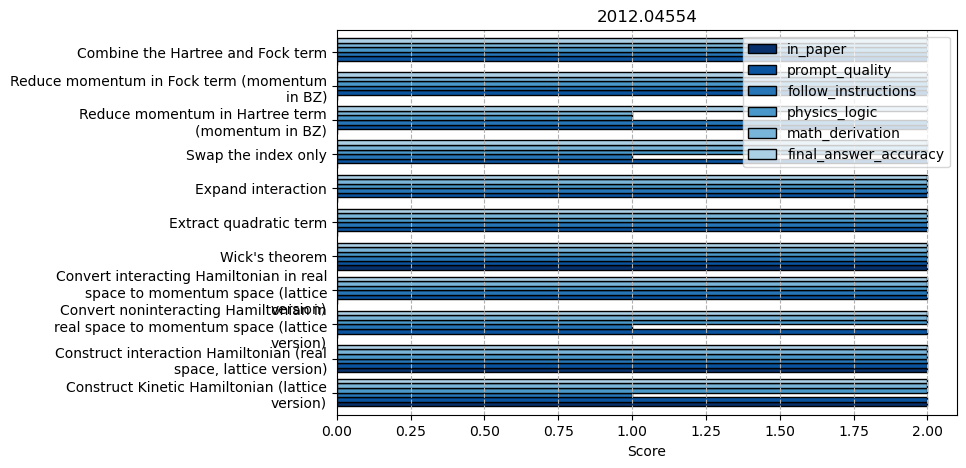

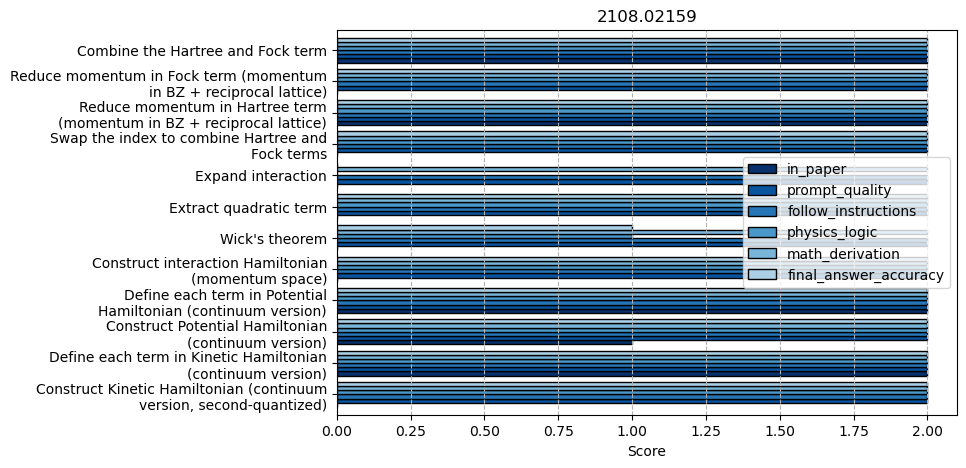

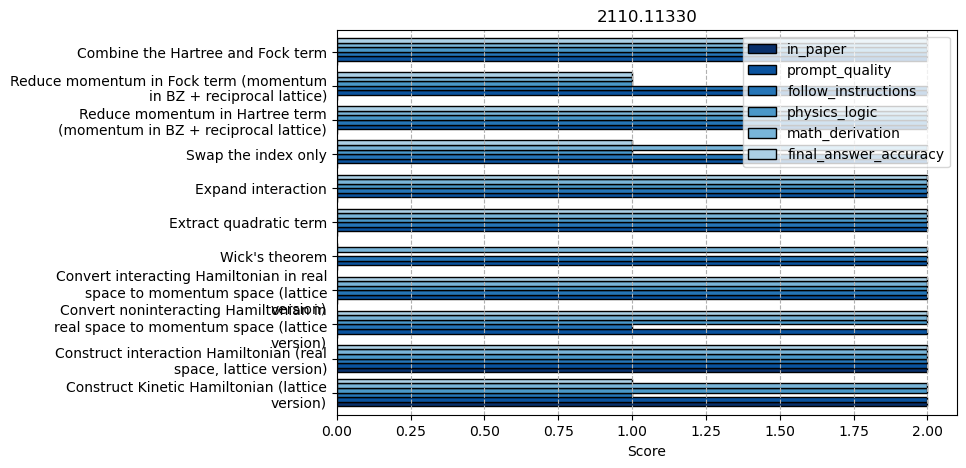

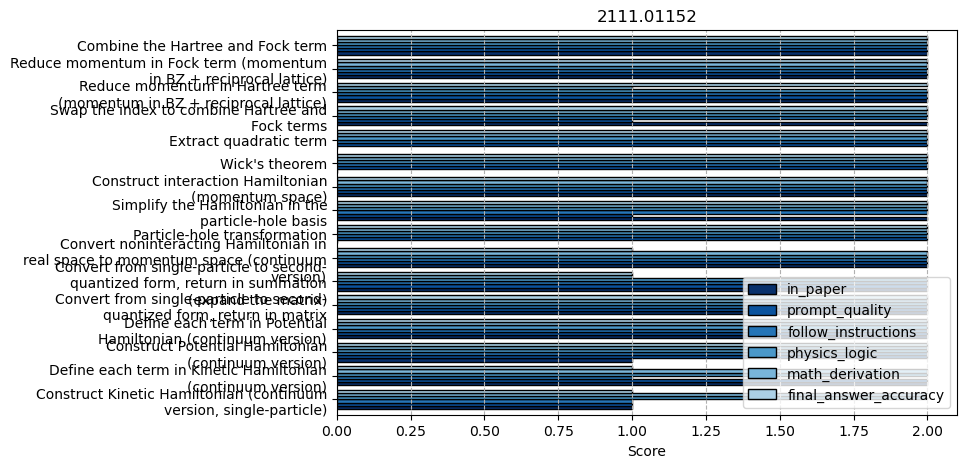

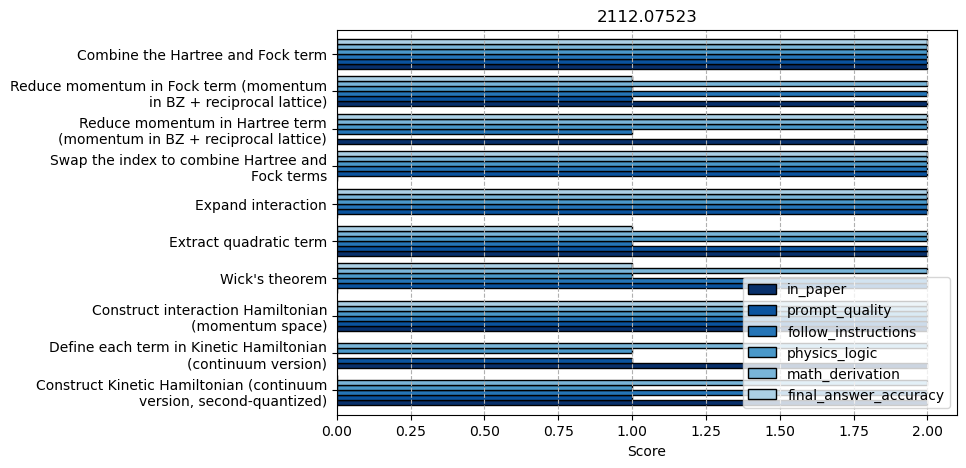

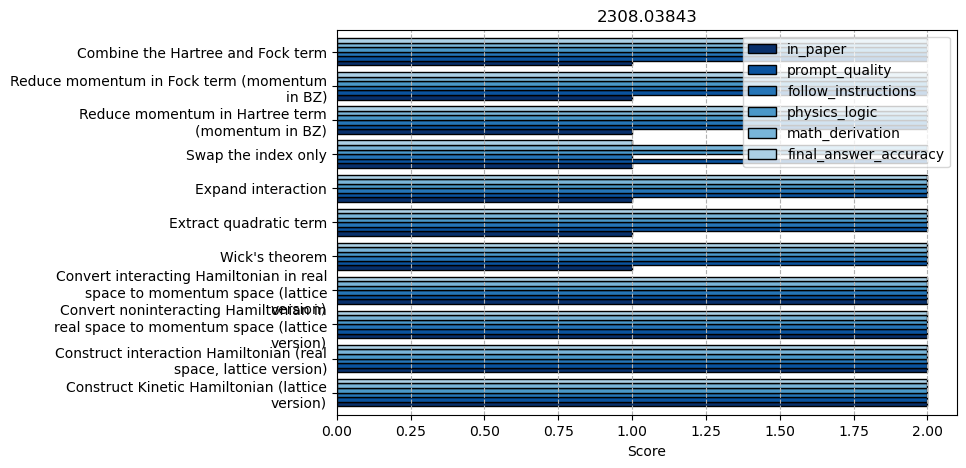

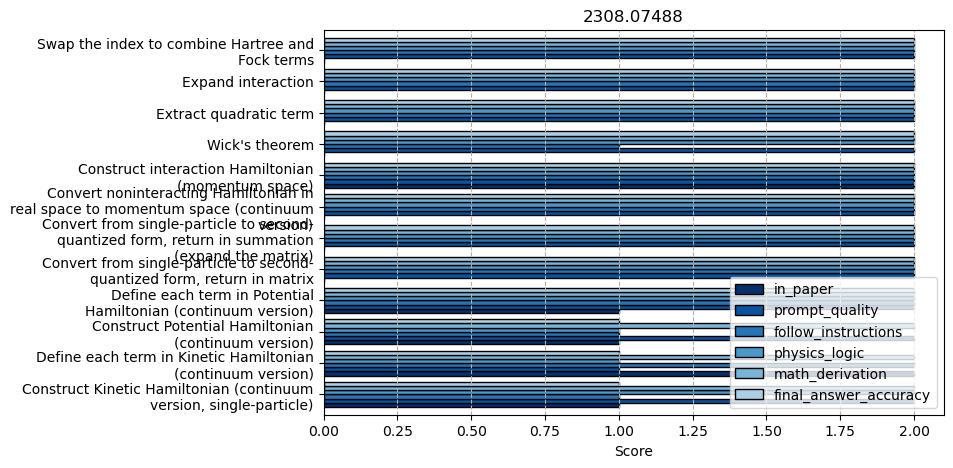

In [11]:
for key,arxiv_df in arxiv_dict_list.items():
    plot_single_file(arxiv_df,key)

# Score by arxiv , compare with reading

In [ ]:
new_col={key:key.replace('_',' ') for key in execution.columns}

In [ ]:
execution=execution.rename(columns=new_col)

In [18]:
execution_groupby_arxiv=execution.groupby('arxiv_number').agg(['mean','sem','count'])

In [19]:
execution_groupby_arxiv[['final answer accuracy']]

final answer accuracy                
                              mean       sem count
arxiv_number                                      
1010.1819                 1.333333  0.256235    12
1106.6060                 1.555556  0.175682     9
1208.0116                 1.727273  0.194978    11
1310.2674                 1.818182  0.121967    11
1812.04213                1.333333  0.224733    12
2004.04168                1.636364  0.152120    11
2008.08998                1.818182  0.121967    11
2012.04554                2.000000  0.000000    11
2108.02159                1.750000  0.179435    12
2110.11330                1.545455  0.207305    11
2111.01152                1.750000  0.111803    16
2112.07523                1.300000  0.260342    10
2308.03843                1.909091  0.090909    11
2308.07488                1.750000  0.130558    12

In [21]:
import pickle

In [22]:
with open('reading_data.pickle','rb') as f:
    reading_data=pickle.load(f)

In [23]:
reading_groupby_arxiv=reading_data.groupby('arxiv').agg(['mean','sem','count'])

In [24]:
reading_groupby_arxiv

Score                
                mean       sem count
arxiv                               
1010.1819   1.181034  0.080849   116
1106.6060   0.750000  0.134810    48
1208.0116   1.446429  0.080057   112
1310.2674   1.111111  0.090680    99
1812.04213  1.194915  0.087837   118
2004.04168  0.708333  0.109125    72
2008.08998  1.613636  0.083096    88
2012.04554  1.058140  0.101095    86
2108.02159  1.163934  0.085819   122
2110.11330  1.181818  0.099036    88
2111.01152  1.601190  0.054809   168
2112.07523  1.693878  0.068662    98
2308.03843  1.350000  0.088048   100
2308.07488  1.140845  0.080944   142

In [25]:
execution_reading=pd.concat([execution_groupby_arxiv[['final answer accuracy']],reading_groupby_arxiv],axis=1,).rename(columns={'final answer accuracy':'Execution','Score':'Extraction'})

In [26]:
execution_reading

Execution                 Extraction                
                mean       sem count       mean       sem count
1010.1819   1.333333  0.256235    12   1.181034  0.080849   116
1106.6060   1.555556  0.175682     9   0.750000  0.134810    48
1208.0116   1.727273  0.194978    11   1.446429  0.080057   112
1310.2674   1.818182  0.121967    11   1.111111  0.090680    99
1812.04213  1.333333  0.224733    12   1.194915  0.087837   118
2004.04168  1.636364  0.152120    11   0.708333  0.109125    72
2008.08998  1.818182  0.121967    11   1.613636  0.083096    88
2012.04554  2.000000  0.000000    11   1.058140  0.101095    86
2108.02159  1.750000  0.179435    12   1.163934  0.085819   122
2110.11330  1.545455  0.207305    11   1.181818  0.099036    88
2111.01152  1.750000  0.111803    16   1.601190  0.054809   168
2112.07523  1.300000  0.260342    10   1.693878  0.068662    98
2308.03843  1.909091  0.090909    11   1.350000  0.088048   100
2308.07488  1.750000  0.130558    12   1.140845  0.080944   142

In [27]:
execution_reading.corr().loc[("Extraction","mean"),("Execution","mean")]

-0.02892591610804187

Text(0.5, 1.0, 'Correlation:-0.0289')

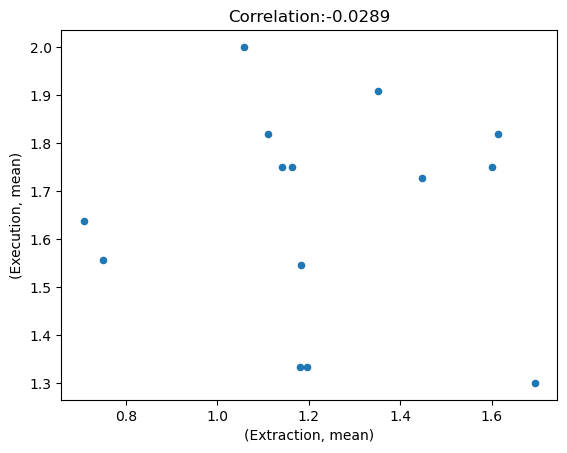

In [28]:
execution_reading.plot(kind='scatter',x=('Extraction','mean'),y=('Execution','mean'))
plt.title(f'Correlation:{execution_reading.corr().loc[("Extraction","mean"),("Execution","mean")]:0.04f}')

Text(0.5, 1.0, 'Mean of Extraction: 1.23 $\\pm$ 0.09\nMean of Execution: 1.66 $\\pm$ 0.16')

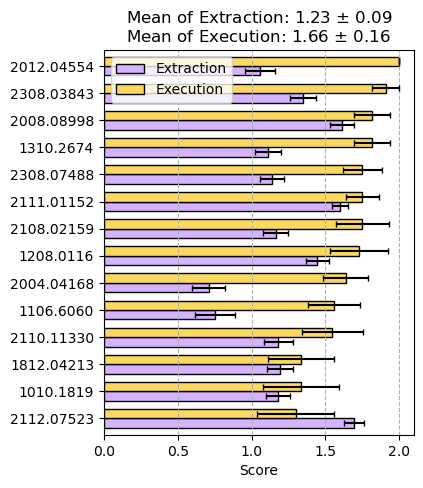

In [29]:
means = execution_reading.sort_values(by=('Execution','mean'))[[("Extraction", "mean"), ("Execution", "mean")]].droplevel(1,axis=1)
errors = execution_reading.sort_values(by=('Execution','mean'))[[("Extraction", "sem"), ("Execution", "sem")]].droplevel(1,axis=1)
ax = means.plot(kind='barh', xerr=errors, capsize=2,figsize=(4,5),color=['#d5b3ff','#fbd960'],edgecolor='k',width=0.7)
ax.grid(axis='x',ls='--')
ax.set_xlabel('Score')
ax.set_title('\n'.join([f'Mean of {kind}: {mean:.2f} $\pm$ {se:.2f}' for kind,mean,se in zip(['Extraction','Execution'],means.mean(),errors.mean())]))


# Score by aspect

In [30]:
execution.mean().iloc[2:]

follow instructions      1.7875
physics logic            1.8000
math derivation          1.9375
final answer accuracy    1.6625
dtype: float64

Text(0.5, 1.0, 'Performance of execution from different aspects')

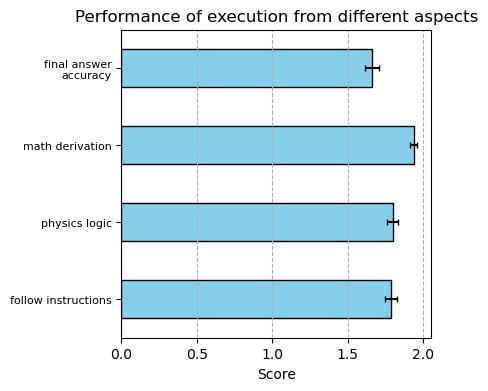

In [31]:
ax=execution.mean().iloc[2:].plot(kind='barh',xerr=execution.sem(),capsize=2,edgecolor='k',figsize=(4,4),color='skyblue')
ax.grid(axis='x',ls='--')
ax.set_xlabel('Score')
ax.set_ylabel('')
ax.set_yticklabels(['\n'.join(textwrap.wrap(task.replace(' ',' '), width=20)) for task in execution.mean().iloc[2:].index],fontsize=8)
ax.set_title('Performance of execution from different aspects')

# Score by task

In [32]:
execution[(execution['final answer accuracy']==2) & (execution.iloc[:,2:-1].mean(axis=1)!=2)]

in paper  \
arxiv_number task                                                           
2004.04168   Swap the index only                                        0   
2008.08998   Combine the Hartree and Fock term                          2   
2012.04554   Construct Kinetic Hamiltonian (lattice version)            2   
             Convert noninteracting Hamiltonian in real spac...         0   
             Swap the index only                                        0   
             Reduce momentum in Hartree term (momentum in BZ)           0   
2110.11330   Convert noninteracting Hamiltonian in real spac...         0   
2111.01152   Reduce momentum in Hartree term (momentum in BZ...         2   
2112.07523   Reduce momentum in Hartree term (momentum in BZ...         2   
2308.07488   Wick's theorem                                             0   

                                                                 prompt quality  \
arxiv_number task                                                                 
2004.04168   Swap the index only                                              2   
2008.08998   Combine the Hartree and Fock term                                2   
2012.04554   Construct Kinetic Hamiltonian (lattice version)                  2   
             Convert noninteracting Hamiltonian in real spac...               2   
             Swap the index only                                              2   
             Reduce momentum in Hartree term (momentum in BZ)                 2   
2110.11330   Convert noninteracting Hamiltonian in real spac...               2   
2111.01152   Reduce momentum in Hartree term (momentum in BZ...               2   
2112.07523   Reduce momentum in Hartree term (momentum in BZ...               0   
2308.07488   Wick's theorem                                                   2   

                                                                 follow instructions  \
arxiv_number task                                                                      
2004.04168   Swap the index only                                                   1   
2008.08998   Combine the Hartree and Fock term                                     1   
2012.04554   Construct Kinetic Hamiltonian (lattice version)                       1   
             Convert noninteracting Hamiltonian in real spac...                    1   
             Swap the index only                                                   1   
             Reduce momentum in Hartree term (momentum in BZ)                      2   
2110.11330   Convert noninteracting Hamiltonian in real spac...                    1   
2111.01152   Reduce momentum in Hartree term (momentum in BZ...                    2   
2112.07523   Reduce momentum in Hartree term (momentum in BZ...                    1   
2308.07488   Wick's theorem                                                        1   

                                                                 physics logic  \
arxiv_number task                                                                
2004.04168   Swap the index only                                             2   
2008.08998   Combine the Hartree and Fock term                               2   
2012.04554   Construct Kinetic Hamiltonian (lattice version)                 2   
             Convert noninteracting Hamiltonian in real spac...              2   
             Swap the index only                                             2   
             Reduce momentum in Hartree term (momentum in BZ)                1   
2110.11330   Convert noninteracting Hamiltonian in real spac...              2   
2111.01152   Reduce momentum in Hartree term (momentum in BZ...              2   
2112.07523   Reduce momentum in Hartree term (momentum in BZ...              2   
2308.07488   Wick's theorem                                                  2   

                                                                 math derivation  \
arxiv_number task

In [33]:
execution_groupby_task=execution.groupby('task').agg(['mean','sem','count'])

In [34]:
with open('../Naming.yaml','r') as f:
    naming=yaml.safe_load(f)

In [161]:
# naming_order=[for key in (naming.keys()) if key in execution_groupby_task]

In [35]:
execution_groupby_task_mean=execution_groupby_task[execution_groupby_task[('in paper','count')]>2].sort_values(by=('final answer accuracy','mean')).loc[:,(slice(None),'mean')].iloc[:,2:].droplevel(1,axis=1)
execution_groupby_task_sem=execution_groupby_task[execution_groupby_task[('in paper','count')]>2].sort_values(by=('final answer accuracy','mean')).loc[:,(slice(None),'sem')].iloc[:,2:].droplevel(1,axis=1)

Text(0.5, 1.0, 'Score of execution by tasks')

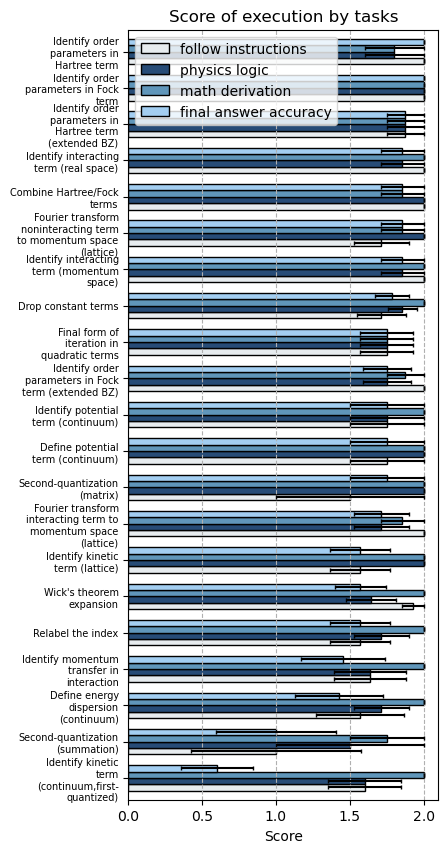

In [36]:
ax=execution_groupby_task_mean.plot(kind='barh',xerr=execution_groupby_task_sem,figsize=(4,10),color=['#e7ecef','#274c77','#6096ba','#a3cef1'],capsize=1.5,edgecolor='k',width=0.7,)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_yticklabels(['\n'.join(textwrap.wrap(naming[task], width=20)) for task in execution_groupby_task_mean.index],fontsize=7)
ax.set_title('Score of execution by tasks')

# Score by task type

In [37]:
with open('../Task_type.yaml','r') as f:
    task_type=yaml.safe_load(f)

In [38]:
task_type_order=['Hamiltonian of QMB problem','Hamiltonian in momentum space','Mean field decomposition','Hartree and Fock terms','Order parameter']

In [39]:
execution.index=pd.MultiIndex.from_tuples([(index[0],task_type[index[1]],index[1]) for index in execution.index.tolist()],names=['arxiv_number','task_type','task'])

In [40]:
execution_groupby_task_type=execution.groupby('task_type').agg(['mean','sem','count'])
# data_groupby_task=data_groupby_task.loc[task_type_order[::-1]]

Text(0.5, 1.0, 'Score of execution by different steps')

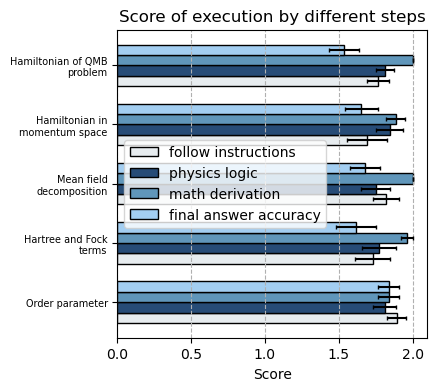

In [41]:
execution_groupby_task_type_mean=execution_groupby_task_type[execution_groupby_task_type[('in paper','count')]>2].loc[task_type_order[::-1]].loc[:,(slice(None),'mean')].iloc[:,2:].droplevel(1,axis=1)
execution_groupby_task_type_sem=execution_groupby_task_type[execution_groupby_task_type[('in paper','count')]>2].loc[task_type_order[::-1]].loc[:,(slice(None),'sem')].iloc[:,2:].droplevel(1,axis=1)
ax=execution_groupby_task_type_mean.plot(kind='barh',xerr=execution_groupby_task_type_sem,figsize=(4,4),color=['#e7ecef','#274c77','#6096ba','#a3cef1'],capsize=1.5,edgecolor='k',width=0.7,)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=20)) for task in execution_groupby_task_type_mean.index],fontsize=7)
ax.set_title('Score of execution by different steps')

# Score by branch

In [42]:
branch_from_arxiv=dict(zip(reading_data.index.get_level_values(1),reading_data.index.get_level_values(0)))

In [45]:
execution.index=pd.MultiIndex.from_tuples([(branch_from_arxiv[index[0]],)+index for index in execution.index.tolist()],names=['branch','arxiv_number','task_type','task'])

In [46]:
execution_groupby_branch=execution.groupby('branch').agg(['mean','sem','count'])

Text(0.5, 1.0, 'Score of execution by branches')

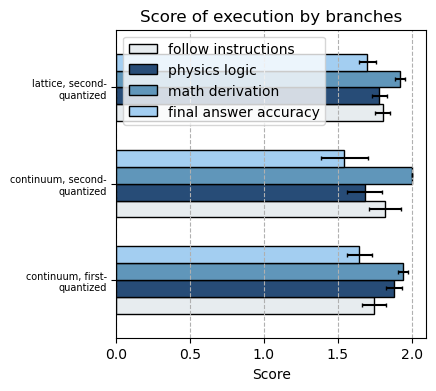

In [47]:
execution_groupby_branch_mean=execution_groupby_branch[execution_groupby_branch[('in paper','count')]>2].loc[:,(slice(None),'mean')].iloc[:,2:].droplevel(1,axis=1)
exeution_groupby_branch_sem=execution_groupby_branch[execution_groupby_branch[('in paper','count')]>2].loc[:,(slice(None),'sem')].iloc[:,2:].droplevel(1,axis=1)
ax=execution_groupby_branch_mean.plot(kind='barh',xerr=exeution_groupby_branch_sem,figsize=(4,4),color=['#e7ecef','#274c77','#6096ba','#a3cef1'],capsize=1.5,edgecolor='k',width=0.7,)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=20)) for task in execution_groupby_branch_mean.index],fontsize=7)
ax.set_title('Score of execution by branches')

# Score conditioned on in paper

In [48]:
execution_groupby_in_paper=execution.groupby('in paper').agg(['mean','sem','count'])

In [49]:
execution_groupby_in_paper

prompt quality                 follow instructions                  \
                   mean       sem count                mean       sem count   
in paper                                                                      
0              1.969231  0.021586    65            1.738462  0.073631    65   
1              1.825000  0.060843    40            1.850000  0.067463    40   
2              1.745455  0.074392    55            1.800000  0.065649    55   

         physics logic                 math derivation                  \
                  mean       sem count            mean       sem count   
in paper                                                                 
0             1.769231  0.064931    65        1.953846  0.026227    65   
1             1.850000  0.067463    40        1.925000  0.042176    40   
2             1.800000  0.060302    55        1.927273  0.043844    55   

         final answer accuracy                  
                          mean       sem count  
in paper                                        
0                     1.692308  0.072467    65  
1                     1.700000  0.081650    40  
2                     1.600000  0.088382    55

Text(0.5, 1.0, 'Overlap between asnwers and training papers')

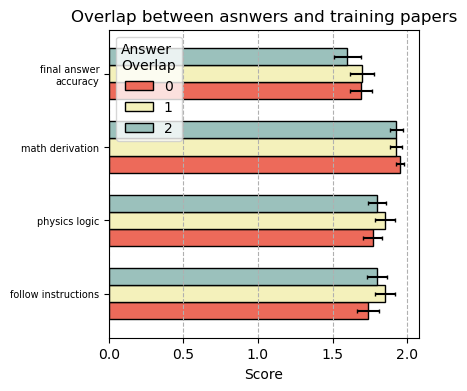

In [50]:
execution_groupby_in_place_mean=execution_groupby_in_paper[execution_groupby_in_paper[('final answer accuracy','count')]>2].loc[:,(slice(None),'mean')].iloc[:,-4:].droplevel(1,axis=1).T
execution_groupby_in_place_sem=execution_groupby_in_paper[execution_groupby_in_paper[('final answer accuracy','count')]>2].loc[:,(slice(None),'sem')].iloc[:,-4:].droplevel(1,axis=1).T
ax=execution_groupby_in_place_mean.plot(kind='barh',xerr=execution_groupby_in_place_sem,figsize=(4,4),color=['#ed6a5a','#f4f1bb','#9bc1bc'],capsize=1.5,edgecolor='k',width=0.7,)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_yticklabels(['\n'.join(textwrap.wrap(task.replace(' ',' '), width=20)) for task in execution_groupby_in_place_mean.index],fontsize=7)
ax.legend().set_title('Answer\nOverlap')
ax.set_title('Overlap between asnwers and training papers')

In [51]:
execution_groupby_branch_mean

,follow instructions,physics logic,math derivation,final answer accuracy
branch,,,,
"continuum, first-quantized",1.745098,1.882353,1.941176,1.647059
"continuum, second-quantized",1.818182,1.681818,2.000000,1.545455
"lattice, second-quantized",1.804598,1.781609,1.919540,1.701149


# Score conditioned on prompt_quality

In [52]:
execution_groupby_prompt_quality=execution.groupby('prompt quality').agg(['mean','sem','count'])

In [53]:
execution_groupby_prompt_quality

in paper                 follow instructions                  \
                    mean       sem count                mean       sem count   
prompt quality                                                                 
0               2.000000  0.000000     3            1.000000  0.577350     3   
1               1.352941  0.170233    17            1.764706  0.136377    17   
2               0.864286  0.073253   140            1.807143  0.041672   140   

               physics logic                 math derivation                  \
                        mean       sem count            mean       sem count   
prompt quality                                                                 
0                   1.000000  0.577350     3        1.333333  0.666667     3   
1                   1.588235  0.123038    17        2.000000  0.000000    17   
2                   1.842857  0.036932   140        1.942857  0.019688   140   

               final answer accuracy                  
                                mean       sem count  
prompt quality                                        
0                           0.666667  0.666667     3  
1                           1.235294  0.182495    17  
2                           1.735714  0.043735   140

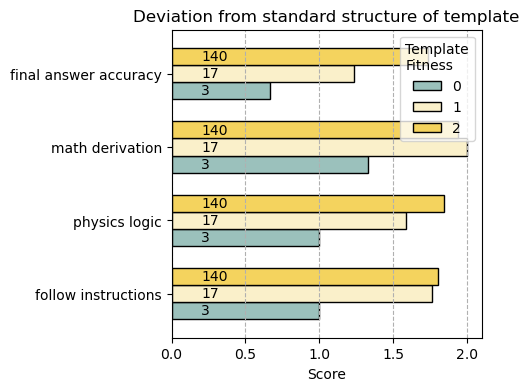

In [54]:
execution_groupby_prompt_quality_mean=execution_groupby_prompt_quality[execution_groupby_prompt_quality[('final answer accuracy','count')]>=2].loc[:,(slice(None),'mean')].iloc[:,-4:].droplevel(1,axis=1).T
execution_groupby_prompt_quality_sem=execution_groupby_prompt_quality[execution_groupby_prompt_quality[('final answer accuracy','count')]>=2].loc[:,(slice(None),'sem')].iloc[:,-4:].droplevel(1,axis=1).T
ax=execution_groupby_prompt_quality_mean.plot(kind='barh',figsize=(4,4),color=['#9bc1bc','#faf0ca','#f4d35e'],capsize=1.5,edgecolor='k',width=0.7,)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
# ax.set_yticklabels(['\n'.join(textwrap.wrap(task.replace(' ',' '), width=20)) for task in execution_groupby_prompt_quality_mean.index],fontsize=7)
ax.set_yticks(np.arange(4))
ax.legend().set_title('Template\nFitness')
ax.set_title('Deviation from standard structure of template')

for index,value in enumerate(execution_groupby_prompt_quality[('in paper','count')]):
# for yval,(xval,val) in enumerate(zip(execution_groupby_prompt_quality[('in paper','count')],))
    for idx in range(4):
        ax.text(0.2, idx+(index-1)*0.7/3, str(value), color='black', va='center')

In [55]:
execution_groupby_branch_mean

,follow instructions,physics logic,math derivation,final answer accuracy
branch,,,,
"continuum, first-quantized",1.745098,1.882353,1.941176,1.647059
"continuum, second-quantized",1.818182,1.681818,2.000000,1.545455
"lattice, second-quantized",1.804598,1.781609,1.919540,1.701149


In [56]:
execution_groupby_task_mean

,follow instructions,physics logic,math derivation,final answer accuracy
task,,,,
"Construct Kinetic Hamiltonian (continuum version, single-particle)",1.600000,1.600000,2.000000,0.600000
"Convert from single-particle to second-quantized form, return in summation (expand the matrix)",1.000000,1.500000,1.750000,1.000000
Define each term in Kinetic Hamiltonian (continuum version),1.571429,1.714286,2.000000,1.428571
Expand interaction,1.636364,1.636364,2.000000,1.454545
Swap the index only,1.571429,1.714286,2.000000,1.571429
Wick's theorem,1.928571,1.642857,2.000000,1.571429
Construct Kinetic Hamiltonian (lattice version),1.571429,2.000000,2.000000,1.571429
Convert interacting Hamiltonian in real space to momentum space (lattice version),2.000000,1.714286,1.857143,1.714286
"Convert from single-particle to second-quantized form, return in matrix",1.500000,2.000000,2.000000,1.750000


# Obsolete

Text(0.5, 0, 'Score')

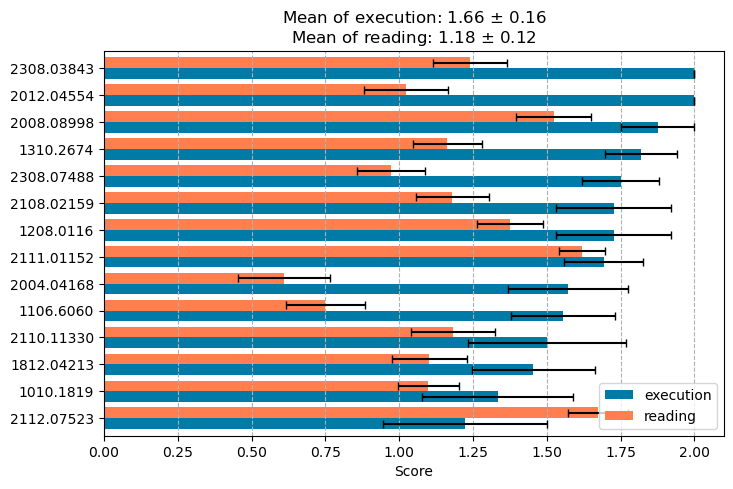

In [ ]:
execution_reading_mean=pd.concat([arxiv_dict_mean,reading_data_mean],axis=1,).rename(columns={'final answer accuracy':'execution','Value':'Extraction'}).sort_values('execution')
execution_reading_se=pd.concat([arxiv_dict_se,reading_data_se],axis=1,).rename(columns={'final answer accuracy':'execution','Value':'Extraction'}).sort_values('execution')

execution_reading_mean.plot(kind='barh',color=['#007BA7', '#FF7F50'],figsize=(8,5),width=0.8,xerr=execution_reading_se,capsize=3)
plt.title('\n'.join([f'Mean of {kind}: {mean:.2f} $\pm$ {se:.2f}' for kind,mean,se in zip(['Execution','Extraction'],execution_reading_mean.mean(),execution_reading_se.mean())]))
plt.grid(axis='x',ls='--')
plt.xlabel('Score')

In [ ]:
color_list=[plt.cm.Blues(0.2+0.8*(i/6)) for i in range(6,0,-1)]

Text(0.5, 0, 'Score')

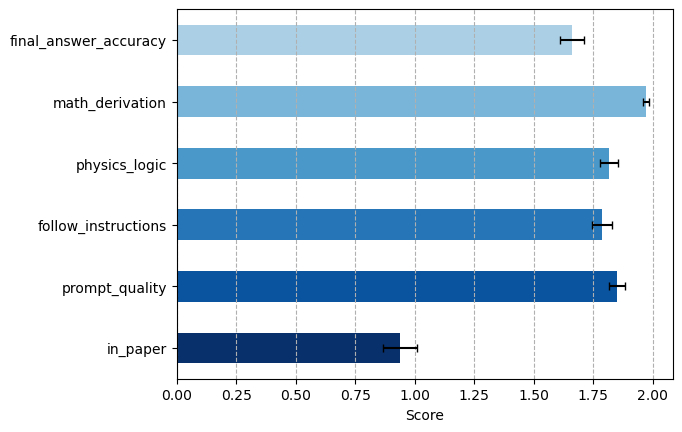

In [ ]:
arxiv_dict.mean().plot(kind='barh',color=[plt.cm.Blues(0.2+0.8*(i/6)) for i in range(6,0,-1)],xerr=arxiv_dict.sem(),capsize=3,)
plt.grid(axis='x',ls='--')
plt.xlabel('Score')

In [ ]:
import pandas as pd

In [ ]:
def load_score(arxiv_number):
    prompt_template='../prompt_template.md'
    # arxiv_number='1106.6060'
    prompt_dict=load_prompt_template(prompt_template)
    with open(os.path.join('..',f'{arxiv_number}',f'{arxiv_number}.yaml'),'r') as f:
        kwargs= yaml.safe_load(f)
    tasks=[f'Task:{idx} '+kwarg['task'] for idx,kwarg in enumerate(kwargs[1:])]
    aspect_score={}
    for kwarg in kwargs[1:]:
        for key,value in (list(kwarg['score'].items())):
            if key not in aspect_score:
                aspect_score[key]=[value]
            else:
                aspect_score[key].append(value)
    return pd.DataFrame(aspect_score,index=tasks)

In [ ]:
df_list=[load_score(arxiv_number) for arxiv_number in arxiv_number_list]

In [ ]:
dfs=pd.concat(df_list,keys=arxiv_number_list,names=['arxiv_number','task'])

In [ ]:
dfs

NameError: name 'dfs' is not defined

Text(0.5, 0, 'Score')

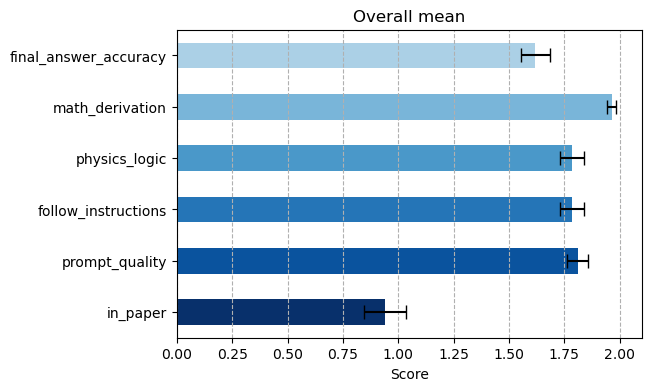

In [ ]:
error_bar=dfs.std().values/dfs.shape[0]**0.5
dfs.mean().plot(kind='barh',figsize=(6,4),xlim=(0,2.1),title='Overall mean',color=color_list,xerr=error_bar,capsize=5)
plt.grid(axis='x',ls='--')
plt.xlabel('Score')

In [ ]:
df.T

,Original Score,Conditional Score
Quality,8,7
Efficiency,6,5
Reliability,7,8
Innovation,9,8


In [ ]:
group='in_paper'
# group='prompt_quality'
mean=arxiv_dict.groupby(group)[['follow_instructions','physics_logic','math_derivation','final answer accuracy']].mean()
error_bar=arxiv_dict.groupby(group)[['follow_instructions','physics_logic','math_derivation','final answer accuracy']].std()/arxiv_dict.groupby(group)[['follow_instructions','physics_logic','math_derivation','final answer accuracy']].count()**0.5


In [ ]:
mean

,follow_instructions,physics_logic,math_derivation,final_answer_accuracy
in_paper,,,,
0,1.727273,1.781818,2.000000,1.672727
1,1.850000,1.850000,1.925000,1.725000
2,1.804348,1.826087,1.978261,1.586957


In [ ]:
list(mean.iterrows())

[(0,
  follow_instructions      1.727273
  physics_logic            1.781818
  math_derivation          2.000000
  final_answer_accuracy    1.672727
  Name: 0, dtype: float64),
 (1,
  follow_instructions      1.850
  physics_logic            1.850
  math_derivation          1.925
  final_answer_accuracy    1.725
  Name: 1, dtype: float64),
 (2,
  follow_instructions      1.804348
  physics_logic            1.826087
  math_derivation          1.978261
  final_answer_accuracy    1.586957
  Name: 2, dtype: float64)]

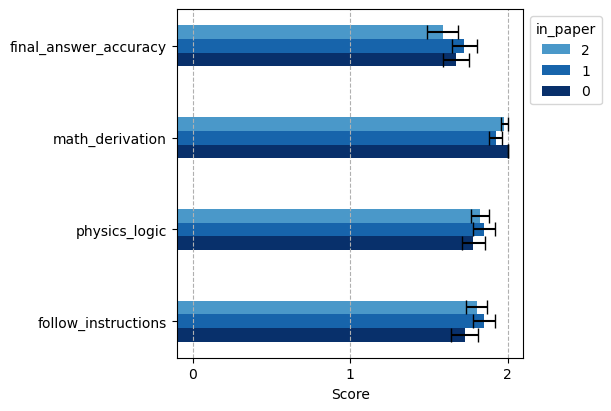

In [ ]:
x = np.arange(mean.shape[1])  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',figsize=(6,4))
color_list=[plt.cm.Blues(0.2+0.8*(i/4)) for i in range(4,0,-1)]
# for attribute, measurement in aspect_score.items():
for attribute, measurement in mean.iterrows():
    offset = width * multiplier
    if not error_bar.loc[attribute].isna().any():
        rects = ax.barh(x + offset, np.array(measurement)+0.1, width, label=attribute,color=color_list[multiplier],left=-0.1,xerr=error_bar.loc[attribute].values,capsize=5)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xlabel('Score')
ax.set_xticks([0,1,2])
# ax.set_title(f"{arxiv_number}")
ax.set_yticks(x + width*1, ['\n'.join(textwrap.wrap(label, width=40)) for label in mean.columns])

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1],loc='upper left', ncols=1,bbox_to_anchor=(1, 1),title=group)

ax.grid(axis='x',ls='--')
# ax.set_ylim(0, 250)
ax.set_xlim(-0.1,2.1)

plt.show()